<h3>Consumer Lending: Default Detection</h3>
1. Given a training data set with 10,000 samples, 600 variables, construct a classification model that outputs the default probability of a customer.
2. Used the model to predict the default probability of another 10,000 potential customers.
3. The motivation for this project is that, by knowing the default probability of a certain customer, we would be able to decide how much we are willing to spend on th

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("train_data.csv")

test_data = pd.read_csv("test_data.csv")

In [3]:
#There are seven rows lack of dependent variables, drop them!
data = data.drop(data['FPD'].isnull()[data['FPD'].isnull()].index).copy()

#Show all the columns of the data frame
pd.set_option('display.max_columns',None)

#fill the 'FPD' of test data as 'N'
test_data['FPD'] = 'N'

In [4]:
#concatenate the training and testing data
whole_data = pd.concat([data, test_data], axis=0)
whole_data = whole_data.reset_index(drop=True)

<h3> Data Preprocessing </h3>
1. remove the dates columns;
2. remove those who have more than 50% missing;
3. impute the data: mean for numerical, most frequent for categorical
4. scale the data

In [5]:
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.base import TransformerMixin

In [6]:
#divide data into three groups-- date, categorical and numerical
num_cols = whole_data.describe().columns
date_cols = ['d02.LastPaymentDate', 'd02.LastInquiryDate', 'd02.LastReturnDate',\
            'd02.LastChargeOffDate', 'd02.ThirdLastPaymentDate','d02.SecondLastPaymentDate',\
            'd02.LastTradelineDate', 'ApplicationDate']
cat_cols = whole_data.drop(whole_data.describe().columns, axis=1).describe().columns.drop(['MRID','FPD'])
cat_cols = cat_cols.drop(date_cols)

In [7]:
#drop the columns that have more than 50% missing data
num_data = whole_data[num_cols].copy()
new_num_cols = num_cols.drop(pd.DataFrame(num_data.isnull().sum(axis=0))\
              [num_data.isnull().sum(axis=0)>len(whole_data)/2].index)

new_num_data = whole_data[new_num_cols].copy()

In [8]:
imp = preprocessing.Imputer(missing_values = 'NaN', strategy='mean', axis=0)
imp.fit(new_num_data)

imp_num_df = pd.DataFrame(imp.transform(new_num_data))

In [9]:
cat_data = whole_data[cat_cols].copy()

#drop the columns that have more than 50% missing data
new_cat_cols = cat_cols.drop(cat_data.isnull().sum()\
            [cat_data.isnull().sum()>0.5*len(cat_data)].index)
new_cat_data = whole_data[new_cat_cols].copy()

In [10]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """
        Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [11]:
#impute, and then turn them to dummies
imp_cat_df = DataFrameImputer().fit_transform(new_cat_data)

cat_df_dummies = pd.get_dummies(imp_cat_df)

In [12]:
imp_df = pd.concat([imp_num_df, cat_df_dummies],axis=1)

In [13]:
#Scale the data
scaled_df = pd.DataFrame(preprocessing.scale(imp_df))

<h3>Data Sets Set-up</h3>
1. PCA to get the top 100+ variables
2. Use logistic to select the top 20~30 variables
3. Construct X and y data sets

In [14]:
pca = decomposition.PCA()
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
# The top X demensions explain Y% of the variance
pca.n_components = sum(pca.explained_variance_ratio_.cumsum()<0.50)
pca.n_components

38

In [16]:
df_reduced = pd.DataFrame(pca.fit_transform(scaled_df))

In [17]:
df_reduced.columns = df_reduced.columns.map(lambda x: 'col'+str(x))

In [18]:
df_reduced.shape

(19053, 38)

In [19]:
X = df_reduced[0:9553].copy()
y = pd.DataFrame(whole_data['FPD'])[0:9553].reset_index(drop = True).copy()
y = y.apply(pd.to_numeric, errors = 'ignore')

In [20]:
X_TEST = df_reduced[9553:].copy()

In [21]:
train_set=np.random.rand(len(y))<0.8

In [22]:
X_train = X[train_set]
y_train = y[train_set]
X_valid = X[~train_set]
y_valid = y[~train_set]

<h3>Functions Definition

In [23]:
def model_performance(X_, y_, model, threshold, result_type):        
    pred_ = list(map(lambda x: x[1], model.predict_proba(X_)))                
    pred_list = list(map(lambda x: 1.0 if x>=threshold else 0.0, pred_))
    df_ = pd.DataFrame(0,index=['True','False'],columns=['Pos','Neg'])
    TP,FP,TN,FN=0,0,0,0
    
    for pred,real in zip(pred_list, list(y_['FPD'])):
        if (pred,real)==(1,1):
            TP+=1
        if (pred,real)==(1,0):
            FN+=1
        if (pred,real)==(0,0):
            TN+=1
        if (pred,real)==(0,1):
            FP+=1

    df_.loc['True','Pos']=TP
    df_.loc['False','Pos']=FP
    df_.loc['True','Neg']=TN
    df_.loc['False','Neg']=FN
    
    if result_type == 'table':
        print(df_)
        print('accuracy:', round((TP+TN)/(TP+TN+FP+FN), 4))
    else:
        return TP,FP,TN,FN

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def roc_plot(X_, y_, model):
    y_true = np.array(y_['FPD'])
    y_score = list(map(lambda x: x[1], model.predict_proba(X_)))        
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [25]:
from sklearn.model_selection import KFold
def predict_distribution(model):
    kf = KFold(n_splits=10)
    pos_dic = dict()
    neg_dic = dict()
    for i in range(10):
        pos_dic[i]=0
        neg_dic[i]=0
    
    for train_index, test_index in kf.split(X):
        train_X, test_X = X.ix[train_index], X.ix[test_index]
        train_y, test_y = y.ix[train_index], y.ix[test_index]        
        model.fit(train_X, train_y)
        y_true = test_y['FPD']
        y_score = list(map(lambda x: x[1], model.predict_proba(test_X)))
        
        for i in range(10):
            left = round(0.1*i, 1)
            right = round(0.1*(i+1), 1)
            index = list(map(lambda x: x<right and x>=left, y_score))
            n_pos = y_true[index].sum()
            n_neg = len(y_true[index]) - y_true[index].sum()
            pos_dic[i] += int(n_pos)
            neg_dic[i] += int(n_neg)
    
    df = pd.DataFrame(columns=['pos','neg','ratio'])    
    for i in range(10):
        left = round(0.1*i, 1)
        right = round(0.1*(i+1), 1)    
        df.loc[str(left) + ', ' + str(right), 'pos'] = pos_dic[i]
        df.loc[str(left) + ', ' + str(right), 'neg'] = neg_dic[i]
        try: rate = round(float(pos_dic[i]/(pos_dic[i]+neg_dic[i])),2)
        except: rate = 'N'
        df.loc[str(left)+', '+str(right), 'ratio'] = rate
    return pd.DataFrame(df)   

<h3> Models

<h5> Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
log_mod = LogisticRegression(class_weight = {1: 5})
log_mod.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight={1: 5}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

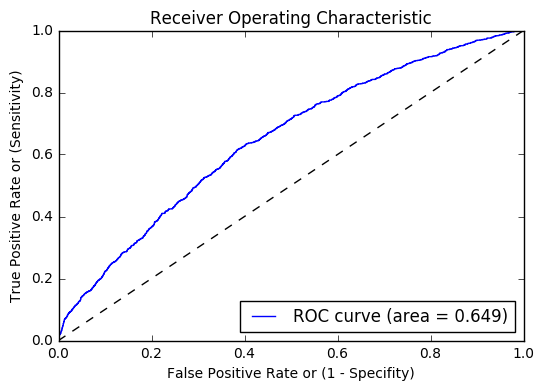

In [28]:
roc_plot(X_train, y_train, log_mod)

<h5>The following table shows the performance of the model, based on a 10-fold cross valiadation:</h5>
<br>
For example, the first row of the logistic regression table shows that there are totally 70 customers being assigned a default probability ranges from 0-10%, while the true distribution is 3 default and 67 non-default. Therefore, the true default rate in this group is 3/(3+67)=4%, which is consistent with the model.

In [29]:
predict_distribution(log_mod)

,pos,neg,ratio
"0.0, 0.1",3,67,0.04
"0.1, 0.2",17,209,0.08
"0.2, 0.3",45,547,0.08
"0.3, 0.4",152,1501,0.09
"0.4, 0.5",499,2960,0.14
"0.5, 0.6",472,1883,0.2
"0.6, 0.7",219,647,0.25
"0.7, 0.8",83,193,0.3
"0.8, 0.9",22,18,0.55
"0.9, 1.0",9,7,0.56


<h5> Neural Network

In [30]:
from sklearn.neural_network import MLPClassifier

In [31]:
nn_mod = MLPClassifier(hidden_layer_sizes=(6,4))
nn_mod.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

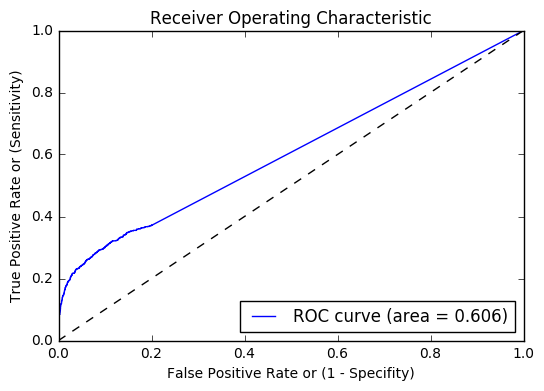

In [32]:
roc_plot(X_train, y_train, nn_mod)

In [33]:
predict_distribution(nn_mod)

,pos,neg,ratio
"0.0, 0.1",239,2140,0.1
"0.1, 0.2",681,3810,0.15
"0.2, 0.3",445,1646,0.21
"0.3, 0.4",98,310,0.24
"0.4, 0.5",27,71,0.28
"0.5, 0.6",7,34,0.17
"0.6, 0.7",9,9,0.5
"0.7, 0.8",6,6,0.5
"0.8, 0.9",8,3,0.73
"0.9, 1.0",1,3,0.25


<h5> SVM

In [34]:
from sklearn import svm

In [35]:
svm_mod = svm.SVC(probability = True)
svm_mod.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

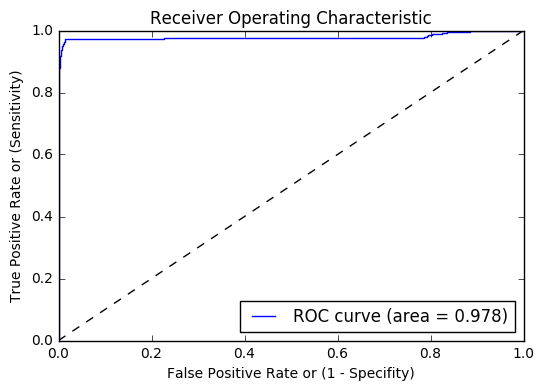

In [36]:
roc_plot(X_train, y_train, svm_mod)

In [37]:
predict_distribution(svm_mod)

,pos,neg,ratio
"0.0, 0.1",1,7,0.12
"0.1, 0.2",1426,7772,0.16
"0.2, 0.3",73,238,0.23
"0.3, 0.4",9,10,0.47
"0.4, 0.5",1,2,0.33
"0.5, 0.6",5,1,0.83
"0.6, 0.7",4,1,0.8
"0.7, 0.8",2,1,0.67
"0.8, 0.9",0,0,N
"0.9, 1.0",0,0,N


<h5> Ensemble: Logistic & Neural Network</h5>
<br>
I tried to ensemble these two models based on an optimal testing AUC and it turned out
that the best weight for logistic is 90%, and the weight for neural network is 10%

In [38]:
from sklearn.model_selection import KFold
def ensemble(X, y, log_esb, nn_esb):
    kf = KFold(n_splits=10)
    whole_list = list()
    
    for train_index, test_index in kf.split(X):
        train_X, test_X = X.ix[train_index], X.ix[test_index]
        train_y, test_y = y.ix[train_index], y.ix[test_index]
        log_esb.fit(train_X, train_y)
        nn_esb.fit(train_X, train_y)
        
        log_score = list(map(lambda x: x[1], log_esb.predict_proba(test_X)))
        nn_score = list(map(lambda x: x[1], nn_esb.predict_proba(test_X)))
        
        auc_list = list()
        for alpha in np.arange(0, 1.01, 0.01):
            score_esb = [alpha*a +(1-alpha)*b for a,b in zip(log_score,nn_score)]
            fpr, tpr, thresholds = roc_curve(test_y['FPD'], score_esb)    
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
                       
        whole_list.append(auc_list)
        result = [sum(e)/len(e) for e in zip(*whole_list)]
    return result

In [39]:
#ensemble: 
log_mod = LogisticRegression(class_weight = {1:5.0})
nn_mod = MLPClassifier(hidden_layer_sizes=(5,3))

a = ensemble(X, y, log_mod, nn_mod)

In [40]:
a.index(max(a))

90

In [41]:
alpha = a.index(max(a))*0.01

In [42]:
log_score = list(map(lambda x: x[1], log_mod.predict_proba(X_valid)))
nn_score = list(map(lambda x: x[1], nn_mod.predict_proba(X_valid)))
score_esb = [alpha*a +(1-alpha)*b for a,b in zip(log_score,nn_score)]

<h3>Conclusion</h3>
In this part, we use logistic regression to test the result

In [43]:
#We use logistic regression model:
from sklearn.linear_model import LogisticRegression
log_mod = LogisticRegression(class_weight = {1: 5})
log_mod.fit(X, y)

LogisticRegression(C=1.0, class_weight={1: 5}, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
#The dafault probability of the customers are
log_TEST = list(map(lambda x: x[1], log_mod.predict_proba(X_TEST)))

In [45]:
y_TEST_data = pd.read_csv('y_TEST.csv')
y_TEST_data = y_TEST_data.set_index('MRID')
mrid = test_data['MRID']
y_TEST = y_TEST_data.ix[mrid]

Based on the prediction of the test data set, the following table shows the prediction result

In [47]:
pos_dic = dict()
neg_dic = dict()
for i in range(10):
    pos_dic[i]=0
    neg_dic[i]=0

y_true = y_TEST['FPD']
y_score = list(map(lambda x: x[1], log_mod.predict_proba(X_TEST)))

for i in range(10):
    left = round(0.1*i, 1)
    right = round(0.1*(i+1), 1)
    index = list(map(lambda x: x<right and x>=left, y_score))
    n_pos = y_true[index].sum()
    n_neg = len(y_true[index]) - y_true[index].sum()
    pos_dic[i] += int(n_pos)
    neg_dic[i] += int(n_neg)

df = pd.DataFrame(columns=['pos','neg','ratio'])    
for i in range(10):
    left = round(0.1*i, 1)
    right = round(0.1*(i+1), 1)    
    df.loc[str(left) + ', ' + str(right), 'pos'] = pos_dic[i]
    df.loc[str(left) + ', ' + str(right), 'neg'] = neg_dic[i]
    try: rate = round(float(pos_dic[i]/(pos_dic[i]+neg_dic[i])),2)
    except: rate = 'N'
    df.loc[str(left)+', '+str(right), 'ratio'] = rate
df

,pos,neg,ratio
"0.0, 0.1",7,135,0.05
"0.1, 0.2",28,498,0.05
"0.2, 0.3",118,1466,0.07
"0.3, 0.4",289,2416,0.11
"0.4, 0.5",340,2239,0.13
"0.5, 0.6",260,1119,0.19
"0.6, 0.7",119,320,0.27
"0.7, 0.8",37,80,0.32
"0.8, 0.9",3,18,0.14
"0.9, 1.0",4,4,0.5
